In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

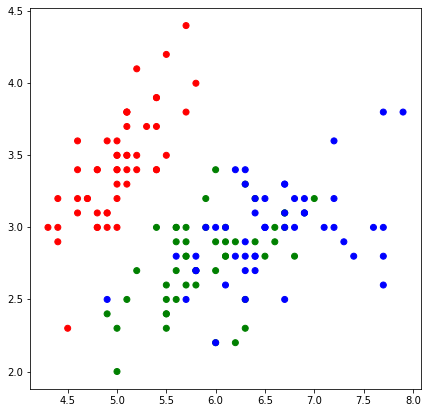

In [4]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [5]:
def e_metrics(x1, x2):
    
    distance = np.sum(np.square(x1 - x2))

    return np.sqrt(distance)

Реализуем алгоритм поиска k ближайших соседей.

In [6]:
## НИЧЕГО НЕ МЕНЯЛ, ЭТО АЛГОРИТМ С УРОКА, ПРОСТО ДЛЯ СРАВНЕНИЯ ДАЛЕЕ

def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

Напишем функцию для вычисления точности

In [7]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

### Задание 1 и 3.
К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.

*Оптимизировать код для KNN (оставить один цикл, либо обойтись без циклов вообще).

Я реализовал добавление соседям весов, зависящих от их порядкового номера.

А сам алгоритм упростил до одного цикла, путем определения расстояния между векторами сразу же для всего x_train, без цикла, с помощью np.linalg.norm с параметром axis=1. А в ранее реализованном алгоритме, мы перебирали все элементы в цикле и искали для каждого вектора расстояние.

In [8]:
def new_knn(x_train, y_train, x_test, k):
    
    answers = []
    
    # Добавим коэффициент, который будем возводить в степень номера соседа i
    q=0.5
    
    # Для каждого вектора x_test:
    for x in x_test:
        
        # Сначала ищем норму(расстояние) между векторами (x_train - x), у нас получается список расстояний.
        # Затем связываем этот список расстояний, с списком классов, к которым эти вектора принадлежат. (list(zip))
        # Потом сортируем этот список расстояний и берем только k соседей (с помощью среза [:k])
        # Затем с помощью np.array[:,1] берем только список классов, так как расстояния нам уже не нужны.
        # В итоге в переменной top у нас есть список классов, находящихся ближе всего к искомому вектору.
        top = np.array(sorted(list(zip(np.linalg.norm(x_train - x, ord=2, axis=1), y_train)))[:k])[:,1]
        
        # с помощью enumerate мы получаем индекс, и добавляем q=0.5 в степени индекса, к нужному классу
        classes = {class_item: 0 for class_item in set(y_train)}
        for i, predict in enumerate(top):
            classes[predict] += q ** i
        # в финальное предсказание идет ключ, в котором value наибольшее.
        answers.append(max(classes, key=classes.get))
        
    return answers

In [9]:
%%time
k = 15

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')
print(y_pred)

Точность алгоритма при k = 15: 0.700
[2, 0, 1, 0, 0, 0, 2, 2, 1, 2, 0, 1, 2, 1, 1, 0, 2, 2, 1, 1, 2, 1, 0, 0, 2, 1, 0, 0, 2, 2]
CPU times: user 41.5 ms, sys: 2.65 ms, total: 44.1 ms
Wall time: 55 ms


In [10]:
%%time
k = 15

y_pred = new_knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')
print(y_pred)

Точность алгоритма при k = 15: 0.700
[2, 0, 1, 0, 0, 0, 2, 2, 1, 1, 0, 1, 1, 2, 1, 0, 2, 1, 1, 1, 2, 1, 0, 0, 2, 1, 0, 0, 2, 2]
CPU times: user 7.46 ms, sys: 1.14 ms, total: 8.6 ms
Wall time: 10.8 ms


Новый алгоритм сработал примерно в 5 раз быстрее старого.

### Задание 3.
*Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

In [11]:
from sklearn.datasets import make_blobs, make_moons

X, y = make_blobs(n_samples=100, random_state=1)
# X, y = make_moons(n_samples=200, noise=0.05, random_state=1)

Изобразим точки на графике.

In [12]:
import matplotlib.pyplot as plt

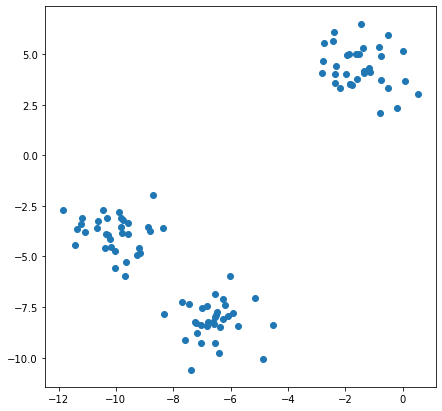

In [13]:
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1]);

In [14]:
def e_metrics(x1, x2):
    
    distance = np.sum(np.square(x1 - x2))

    return np.sqrt(distance)

In [15]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для кластеризации
    clusters = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # кластеризуем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            cluster = distances.index(min(distances))
            clusters[cluster].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for cluster in clusters:
            centroids[cluster] = np.mean(clusters[cluster], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.linalg.norm(centroids[centroid] - old_centroids[centroid], ord=2) > min_distance:
                optimal = False
                break
        
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, clusters

Напишем функцию для визуализации кластеров

In [16]:
def visualize(centroids, clusters):
    colors = ['r', 'g', 'b', 'orange', 'y']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for cluster_item in clusters:
        for x in clusters[cluster_item]:
            plt.scatter(x[0], x[1], color=colors[cluster_item])
            
    plt.show()

In [17]:
## ИЗМЕНЕНИЕ: создание функциии для подсчета среднего квадратичного внутрикластерного расстояния.
def mean_squared_cluster(centroids, clusters):
    error = []
    for i, centroid in enumerate(centroids):
        error.append(sum(np.linalg.norm(centroids[i] - clusters[i], ord=2, axis=1)**2))
    return np.mean(error)

In [18]:
# Зададим список от 1 до 10 для k:
k_list = np.arange(1, 11, 1)
max_iterations = 5
min_distance = 1e-4
# список для записи ошибок:
errors_list = []

for k in k_list:
    centroids, clusters = kmeans(X, k, max_iterations, min_distance)
    errors_list.append(mean_squared_cluster(centroids, clusters))

In [19]:
# список наших ошибок:
errors_list

[8236.307555408945,
 661.5698490972001,
 412.99580872923275,
 221.88588198984138,
 132.73958331079027,
 97.64635136379373,
 73.60636223559702,
 62.484776681810196,
 42.14092168957782,
 34.42460114275477]

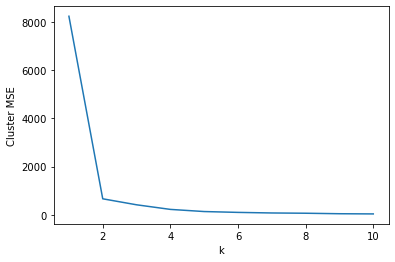

In [20]:
plt.plot(k_list, errors_list)
plt.xlabel('k')
plt.ylabel('Cluster MSE')
plt.show();

Судя по всему, с увеличением количества кластеров, увеличивается количество центроид, а значит, точки становятся все ближе и ближе к центроидам, ошибка уменьшается. Если следовать такой логике, то при k=количеству объектов, MSE должен равняться нулю, так как каждая точка будет принадлежать своей центроиде. Проверим:

In [21]:
k = len(X)
centroids, clusters = kmeans(X, k, max_iterations, min_distance)
print('При k = количеству объектов, среднее квадратичное внутрикластерное расстояние =', \
      mean_squared_cluster(centroids, clusters))

При k = количеству объектов, среднее квадратичное внутрикластерное расстояние = 0.0
